## Libraries

In [1]:
# Main
import os
import math
import time
import warnings
import numpy as np
import joblib
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import resampy
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# MFlow
import mlflow
import mlflow.xgboost
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import dagshub

# ML models
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Data processing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, classification_report, 
                           confusion_matrix, f1_score, accuracy_score)

## Parameters

In [2]:
# Parámetros de audio
SAMPLE_RATE = 16000  # Hz
SEGMENT_DURATION = 10.0  # segundos
VGGISH_HOP_SIZE = 0.96  # segundos
EMBEDDING_SIZE = 128  # tamaño de los embeddings
NUM_SEGMENTS_PER_CHUNK = int(SEGMENT_DURATION / VGGISH_HOP_SIZE)
MODEL_OBJECTS_DIR = 'model_objects/'
TFRECORD_PATH = '../data/raw/bal_train/--.tfrecord'  # Example tfrecord

In [3]:
# Configuración
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuración MLflow
dagshub_repo_owner = "felytz"
dagshub_repo_name = "waveled"
mlflow.set_tracking_uri(f"https://dagshub.com/{dagshub_repo_owner}/{dagshub_repo_name}.mlflow")

# Cargar modelo VGGish
VGGISH_MODEL_URL = "https://tfhub.dev/google/vggish/1"
try:
    vggish_model = hub.load(VGGISH_MODEL_URL)
    print("✅ Modelo VGGish cargado correctamente")
except Exception as e:
    print(f"❌ Error cargando VGGish: {str(e)}")
    exit()

✅ Modelo VGGish cargado correctamente


## Functions

In [17]:
def load_mlflow_model(model_name):
    """Improved model loading with better error handling"""
    try:
        # First try to load as a specific flavor
        for flavor_loader in [mlflow.sklearn.load_model, 
                            mlflow.xgboost.load_model, 
                            mlflow.pyfunc.load_model]:
            try:
                model = flavor_loader(f"models:/{model_name}/latest")
                print(f"✅ Model {model_name} loaded successfully as {flavor_loader.__name__}")
                return model
            except Exception:
                continue
        
        # If all flavor-specific loaders fail
        raise Exception(f"No suitable loader found for {model_name}")
        
    except Exception as e:
        print(f"❌ Error loading model {model_name}: {str(e)}")
        return None

def check_model_type(model):
    """Verifica el tipo de modelo cargado"""
    if hasattr(model, '_model_impl'):
        print(f"Tipo de modelo: {type(model._model_impl)}")
    else:
        print(f"Tipo de modelo: {type(model)}")
    
    print("Capacidades disponibles:")
    print(f"- predict: {hasattr(model, 'predict')}")
    print(f"- predict_proba: {hasattr(model, 'predict_proba')}")
    print(f"- decision_function: {hasattr(model, 'decision_function')}")

def enhance_linear_svc(model):
    """Envuelve un LinearSVC para proporcionar probabilidades"""
    
    if isinstance(model, LinearSVC):
        print("⚙️ Añadiendo calibración de probabilidades a LinearSVC")
        return CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    return model

def load_audio(mp3_path):
    """
    Carga un archivo MP3 usando librosa y devuelve el audio y su duración.
    
    Args:
        mp3_path: Ruta al archivo MP3
        
    Returns:
        y: Array de muestras de audio
        duration: Duración en segundos
    """
    try:
        # Cargar audio con librosa
        y, sr = librosa.load(mp3_path, sr=None, mono=True)
        
        # Re-muestrear si es necesario
        if sr != SAMPLE_RATE:
            y = resampy.resample(y, sr, SAMPLE_RATE)
        
        duration = librosa.get_duration(y=y, sr=SAMPLE_RATE)
        return y, duration
    
    except Exception as e:
        print(f"❌ Error cargando el archivo {mp3_path}: {str(e)}")
        return None, 0

def split_audio(audio_samples, segment_duration=SEGMENT_DURATION):
    """
    Divide el audio en segmentos del tamaño especificado.
    """
    samples_per_segment = int(SAMPLE_RATE * segment_duration)
    num_segments = math.ceil(len(audio_samples) / samples_per_segment)
    
    segments = []
    for i in range(int(num_segments)):
        start = i * samples_per_segment
        end = start + samples_per_segment
        segment = audio_samples[start:end]
        
        # Rellenar el último segmento si es necesario
        if len(segment) < samples_per_segment:
            segment = np.pad(segment, (0, samples_per_segment - len(segment)), 
                            mode='constant')
        
        segments.append(segment)
    
    return segments, num_segments

def extract_vggish_embeddings(audio_segment):
    """
    Extrae embeddings de un segmento de audio usando VGGish.
    """
    try:
        # Convertir a tensor y normalizar
        audio_tensor = tf.convert_to_tensor(audio_segment, dtype=tf.float32)
        
        # Extraer embeddings
        embeddings = vggish_model(audio_tensor).numpy()
        
        # Asegurar la forma correcta
        if embeddings.shape[0] < NUM_SEGMENTS_PER_CHUNK:
            pad_shape = [(0, NUM_SEGMENTS_PER_CHUNK - embeddings.shape[0]), (0, 0)]
            embeddings = np.pad(embeddings, pad_shape, mode='constant')
        else:
            embeddings = embeddings[:NUM_SEGMENTS_PER_CHUNK]
        
        # Normalizar como en AudioSet
        embeddings = (embeddings - 127.5) / 127.5
        return embeddings
    
    except Exception as e:
        print(f"❌ Error extrayendo embeddings: {str(e)}")
        return np.zeros((NUM_SEGMENTS_PER_CHUNK, EMBEDDING_SIZE))

def process_audio_segments(mp3_path, model, use_pca=False):
    """
    Procesa un archivo MP3 completo y devuelve predicciones por segmento.
    """
    # Cargar audio
    y, duration = load_audio(mp3_path)
    if y is None:
        return None, None, 0
    
    print(f"🎵 Audio cargado: {duration:.2f} segundos")
    
    # Dividir en segmentos
    segments, num_segments = split_audio(y)
    print(f"🔧 Dividido en {num_segments} segmentos de {SEGMENT_DURATION} segundos")
    
    # Procesar cada segmento
    predictions = []
    probabilities = []
    
    for i, segment in enumerate(segments):
        try:
            # Extraer embeddings
            embeddings = extract_vggish_embeddings(segment)
            
            # Preparar características
            flattened = embeddings.flatten().reshape(1, -1)
            scaled = scaler.transform(flattened)
            
            if use_pca:
                scaled = pca.transform(scaled)
                scaled = scaler_pca.transform(scaled)
            
            # Predecir
            pred = model.predict(scaled)[0]
            proba = model.predict_proba(scaled)[0][1]  # Probabilidad de ser música
            
            predictions.append(pred)
            probabilities.append(proba)
            
            print(f"Segmento {i+1}: {'MÚSICA' if pred == 1 else 'NO MÚSICA'} ({proba:.2%})")
            
        except Exception as e:
            print(f"❌ Error procesando segmento {i+1}: {str(e)}")
            predictions.append(0)
            probabilities.append(0.0)
    
    return predictions, probabilities, duration

def predict_with_model(model, features):
    """
    Realiza predicciones adaptándose a las capacidades de cada modelo
    Devuelve: (predicción, probabilidad)
    """
    try:
        # Modelos con predict_proba (LogisticRegression, RandomForest, XGBoost)
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(features)[0][1]
            pred = model.predict(features)[0]
            return pred, proba
        
        # Modelos con decision_function pero sin predict_proba (LinearSVC)
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(features)[0]
            pred = model.predict(features)[0]
            # Convertir score de decisión a probabilidad aproximada
            proba = 1 / (1 + np.exp(-decision))  # Función sigmoide
            return pred, proba
        
        # Modelos solo con predict
        else:
            pred = model.predict(features)[0]
            return pred, 1.0 if pred == 1 else 0.0  # Valor dummy para consistencia
            
    except Exception as e:
        print(f"❌ Error en predicción: {str(e)}")
        return 0, 0.0

# Función principal de análisis
# Función principal de análisis mejorada
def analyze_audio_file(mp3_path, model_name="XGBoost", model=None):
    """Analiza un archivo de audio completo con un modelo específico"""
    print(f"\n🔍 Iniciando análisis de: {mp3_path} usando {model_name}")
    
    # Usar el modelo pre-cargado si no se proporciona uno
    if model is None:
        if model_name in models:
            model = models[model_name]
        else:
            print(f"❌ Modelo {model_name} no encontrado en los modelos cargados")
            return
    
    # Cargar y dividir audio
    y, duration = load_audio(mp3_path)
    if y is None:
        return
    
    segments, num_segments = split_audio(y)
    print(f"🔧 Dividido en {num_segments} segmentos de {SEGMENT_DURATION} segundos")
    
    # Procesar cada segmento
    predictions = []
    probabilities = []
    
    for i, segment in enumerate(segments):
        try:
            # Extraer y preparar características
            embeddings = extract_vggish_embeddings(segment)
            flattened = embeddings.flatten().reshape(1, -1)
            scaled = scaler.transform(flattened)
            
            # Manejar PCA de manera más robusta
            use_pca = any(keyword in model_name for keyword in ['PCA', 'pca'])
            if use_pca:
                scaled = pca.transform(scaled)
                scaled = scaler_pca.transform(scaled)
            
            # Predecir
            pred, proba = predict_with_model(model, scaled)
            
            predictions.append(pred)
            probabilities.append(proba)
            
            print(f"Segmento {i+1}: {'MÚSICA' if pred == 1 else 'NO MÚSICA'} ({proba:.2%})")
            
        except Exception as e:
            print(f"❌ Error procesando segmento {i+1}: {str(e)}")
            predictions.append(0)
            probabilities.append(0.0)
    
    # Visualización
    visualize_results(predictions, probabilities, duration, model_name)

def visualize_results(predictions, probabilities, duration, model_name):
    """Visualiza los resultados del análisis"""
    num_segments = len(predictions)
    time_axis = np.linspace(0, duration, num_segments, endpoint=False)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    plt.suptitle(f'Análisis de Música: {model_name}\nDuración: {duration:.2f}s')
    
    # Gráfico de clasificación
    colors = ['red' if p == 0 else 'green' for p in predictions]
    ax1.bar(time_axis, [1]*num_segments, width=SEGMENT_DURATION, 
            color=colors, alpha=0.6, align='edge')
    ax1.set_ylabel('Clasificación')
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['No música', 'Música'])
    ax1.grid(True, axis='x', alpha=0.3)
    
    # Gráfico de probabilidades
    ax2.bar(time_axis, probabilities, width=SEGMENT_DURATION, 
            color='blue', alpha=0.6, align='edge')
    ax2.set_xlabel('Tiempo (segundos)')
    ax2.set_ylabel('Probabilidad')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Leyenda y estadísticas
    legend_elements = [
        Patch(facecolor='green', label='Música', alpha=0.6),
        Patch(facecolor='red', label='No música', alpha=0.6)
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    music_segments = sum(predictions)
    music_percentage = music_segments / num_segments * 100
    avg_prob = np.mean(probabilities) * 100
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Resumen:")
    print(f"- Segmentos de música: {music_segments}/{num_segments} ({music_percentage:.1f}%)")
    print(f"- Probabilidad promedio: {avg_prob:.1f}%")
    print("🎼 CONCLUSIÓN: El audio es PREDOMINANTEMENTE MÚSICA" if music_percentage > 50 
          else "🔇 CONCLUSIÓN: El audio NO ES PREDOMINANTEMENTE MÚSICA")

## Running

In [8]:
# Cargar objetos de preprocesamiento
try:
    scaler = joblib.load(os.path.join(MODEL_OBJECTS_DIR, 'scaler.joblib'))
    pca = joblib.load(os.path.join(MODEL_OBJECTS_DIR, 'pca.joblib'))
    scaler_pca = joblib.load(os.path.join(MODEL_OBJECTS_DIR, 'scaler_pca.joblib'))
    print("✅ Objetos de preprocesamiento cargados correctamente")
except Exception as e:
    print(f"❌ Error cargando objetos de preprocesamiento: {str(e)}")
    raise

✅ Objetos de preprocesamiento cargados correctamente


In [13]:
# Get all registered models
client = MlflowClient()
registered_models = client.search_registered_models()

In [14]:
# Create models dictionary
models = {}
for model_info in registered_models:
    model_name = model_info.name
    try:
        if model_name == 'LinearSVC_PCA':
            # Special handling for LinearSVC
            print(f"Loading and enhancing {model_name}...")
            base_model = load_mlflow_model(model_name)
            models[model_name] = enhance_linear_svc(base_model)
        if model_name == 'LogisticRegression':
            continue
        else:
            # Standard loading for other models
            print(f"Loading {model_name}...")
            models[model_name] = load_mlflow_model(model_name)
    except Exception as e:
        print(f"❌ Failed to load model {model_name}: {str(e)}")
        continue

Loading and enhancing LinearSVC_PCA...


✅ Model LinearSVC_PCA loaded successfully as load_model
⚙️ Añadiendo calibración de probabilidades a LinearSVC
Loading LinearSVC_PCA...


✅ Model LinearSVC_PCA loaded successfully as load_model
Loading LogisticRegression_PCA...


✅ Model LogisticRegression_PCA loaded successfully as load_model
Loading RandomForest...


✅ Model RandomForest loaded successfully as load_model
Loading XGBoost...


✅ Model XGBoost loaded successfully as load_model



⚙️ Comenzando análisis con modelo: LinearSVC_PCA

🔍 Iniciando análisis de: ejemplo_audio.mp3 usando LinearSVC_PCA
🔧 Dividido en 17 segmentos de 10.0 segundos
Segmento 1: NO MÚSICA (31.84%)
Segmento 2: NO MÚSICA (31.80%)
Segmento 3: NO MÚSICA (31.81%)
Segmento 4: NO MÚSICA (31.80%)
Segmento 5: NO MÚSICA (31.81%)
Segmento 6: NO MÚSICA (31.81%)
Segmento 7: NO MÚSICA (31.82%)
Segmento 8: NO MÚSICA (31.83%)
Segmento 9: NO MÚSICA (31.81%)
Segmento 10: NO MÚSICA (31.80%)
Segmento 11: NO MÚSICA (31.81%)
Segmento 12: NO MÚSICA (31.83%)
Segmento 13: NO MÚSICA (31.82%)
Segmento 14: NO MÚSICA (31.78%)
Segmento 15: NO MÚSICA (31.79%)
Segmento 16: NO MÚSICA (31.81%)
Segmento 17: NO MÚSICA (31.86%)


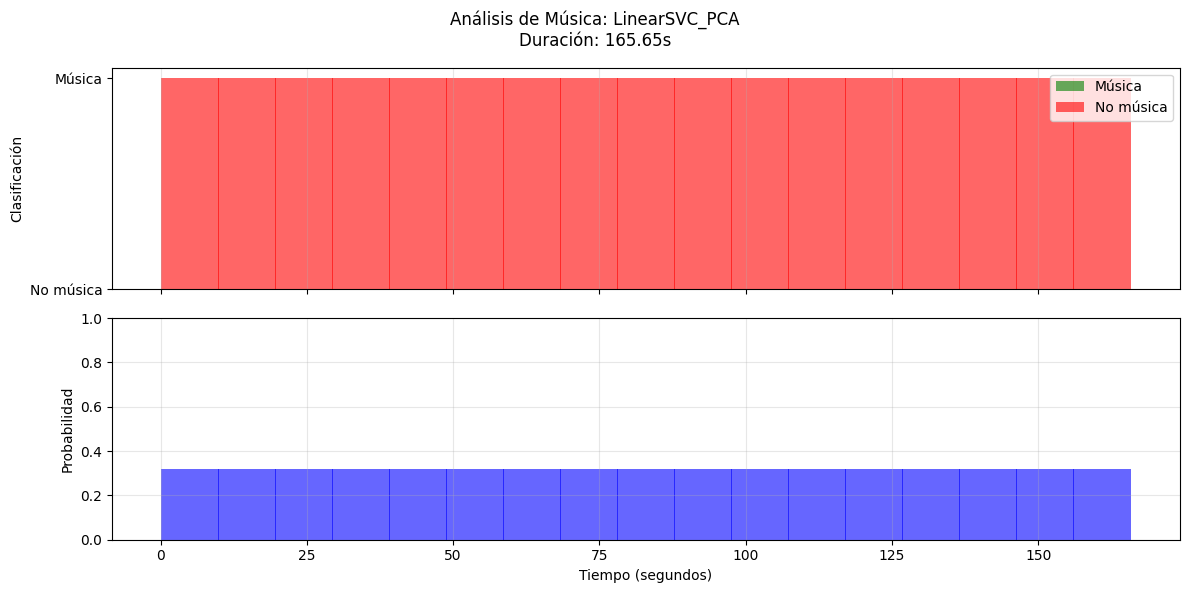


📊 Resumen:
- Segmentos de música: 0.0/17 (0.0%)
- Probabilidad promedio: 31.8%
🔇 CONCLUSIÓN: El audio NO ES PREDOMINANTEMENTE MÚSICA

⚙️ Comenzando análisis con modelo: LogisticRegression_PCA

🔍 Iniciando análisis de: ejemplo_audio.mp3 usando LogisticRegression_PCA
🔧 Dividido en 17 segmentos de 10.0 segundos
Segmento 1: NO MÚSICA (12.61%)
Segmento 2: NO MÚSICA (12.64%)
Segmento 3: NO MÚSICA (12.61%)
Segmento 4: NO MÚSICA (12.62%)
Segmento 5: NO MÚSICA (12.62%)
Segmento 6: NO MÚSICA (12.62%)
Segmento 7: NO MÚSICA (12.62%)
Segmento 8: NO MÚSICA (12.61%)
Segmento 9: NO MÚSICA (12.60%)
Segmento 10: NO MÚSICA (12.61%)
Segmento 11: NO MÚSICA (12.60%)
Segmento 12: NO MÚSICA (12.61%)
Segmento 13: NO MÚSICA (12.62%)
Segmento 14: NO MÚSICA (12.62%)
Segmento 15: NO MÚSICA (12.58%)
Segmento 16: NO MÚSICA (12.60%)
Segmento 17: NO MÚSICA (12.67%)


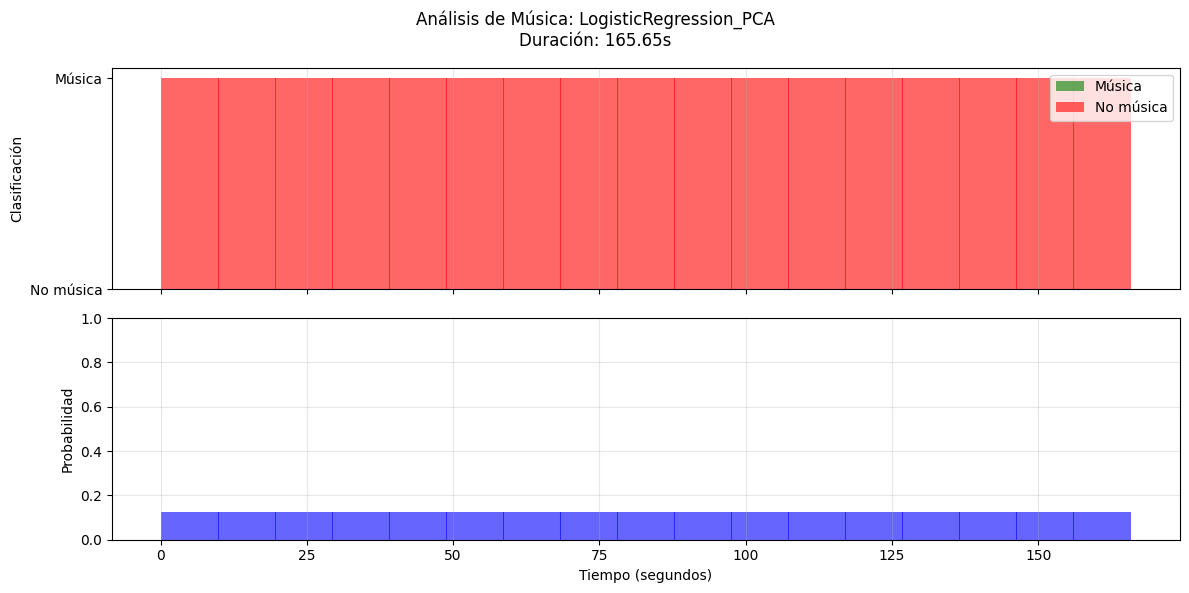


📊 Resumen:
- Segmentos de música: 0.0/17 (0.0%)
- Probabilidad promedio: 12.6%
🔇 CONCLUSIÓN: El audio NO ES PREDOMINANTEMENTE MÚSICA

⚙️ Comenzando análisis con modelo: RandomForest

🔍 Iniciando análisis de: ejemplo_audio.mp3 usando RandomForest
🔧 Dividido en 17 segmentos de 10.0 segundos
Segmento 1: NO MÚSICA (36.59%)
Segmento 2: NO MÚSICA (36.59%)
Segmento 3: NO MÚSICA (36.59%)
Segmento 4: NO MÚSICA (36.59%)
Segmento 5: NO MÚSICA (36.59%)
Segmento 6: NO MÚSICA (36.59%)
Segmento 7: NO MÚSICA (36.59%)
Segmento 8: NO MÚSICA (36.59%)
Segmento 9: NO MÚSICA (36.59%)
Segmento 10: NO MÚSICA (36.59%)
Segmento 11: NO MÚSICA (36.59%)
Segmento 12: NO MÚSICA (36.59%)
Segmento 13: NO MÚSICA (36.59%)
Segmento 14: NO MÚSICA (36.59%)
Segmento 15: NO MÚSICA (36.59%)
Segmento 16: NO MÚSICA (36.59%)
Segmento 17: NO MÚSICA (36.59%)


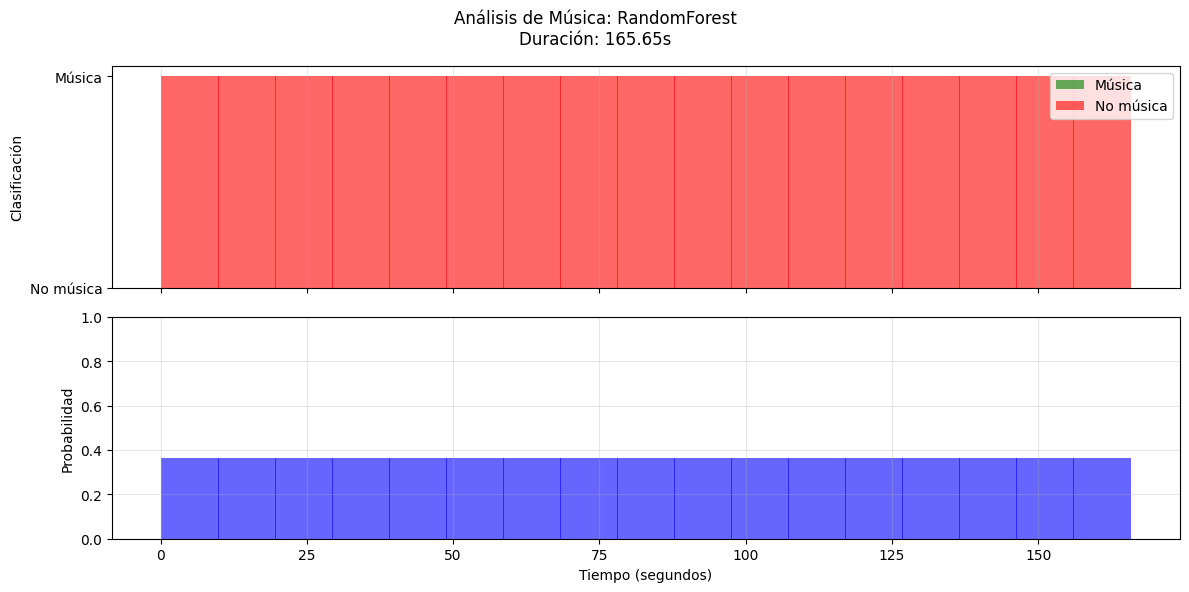


📊 Resumen:
- Segmentos de música: 0.0/17 (0.0%)
- Probabilidad promedio: 36.6%
🔇 CONCLUSIÓN: El audio NO ES PREDOMINANTEMENTE MÚSICA

⚙️ Comenzando análisis con modelo: XGBoost

🔍 Iniciando análisis de: ejemplo_audio.mp3 usando XGBoost
🔧 Dividido en 17 segmentos de 10.0 segundos
Segmento 1: NO MÚSICA (18.36%)
Segmento 2: NO MÚSICA (18.36%)
Segmento 3: NO MÚSICA (18.36%)
Segmento 4: NO MÚSICA (18.36%)
Segmento 5: NO MÚSICA (18.36%)
Segmento 6: NO MÚSICA (18.36%)
Segmento 7: NO MÚSICA (18.36%)
Segmento 8: NO MÚSICA (18.36%)
Segmento 9: NO MÚSICA (18.36%)
Segmento 10: NO MÚSICA (18.36%)
Segmento 11: NO MÚSICA (18.36%)
Segmento 12: NO MÚSICA (18.36%)
Segmento 13: NO MÚSICA (18.36%)
Segmento 14: NO MÚSICA (18.36%)
Segmento 15: NO MÚSICA (16.86%)
Segmento 16: NO MÚSICA (18.36%)
Segmento 17: NO MÚSICA (18.36%)


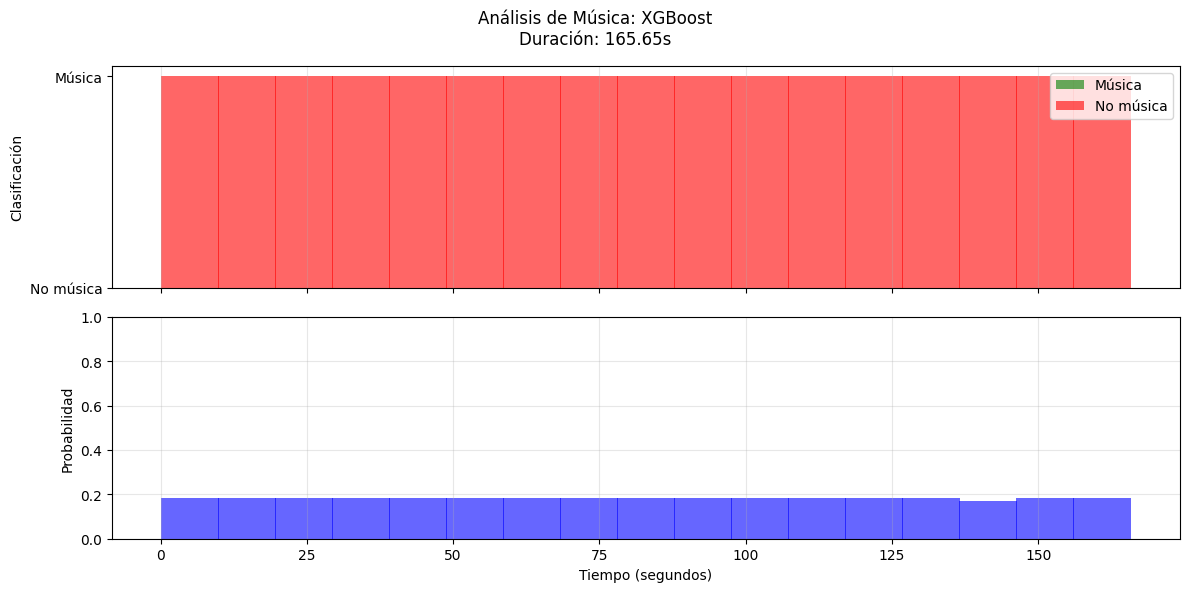


📊 Resumen:
- Segmentos de música: 0/17 (0.0%)
- Probabilidad promedio: 18.3%
🔇 CONCLUSIÓN: El audio NO ES PREDOMINANTEMENTE MÚSICA


In [18]:
# Ejemplo de uso mejorado
if __name__ == "__main__":
    audio_file = "ejemplo_audio.mp3"
    
    if not os.path.exists(audio_file):
        print(f"❌ El archivo {audio_file} no existe")
    else:
        # Analizar con todos los modelos disponibles
        for model_name, model in models.items():
            try:
                print(f"\n{'='*50}")
                print(f"⚙️ Comenzando análisis con modelo: {model_name}")
                analyze_audio_file(audio_file, model_name, model)
            except Exception as e:
                print(f"❌ Error al analizar con {model_name}: {str(e)}")
                traceback.print_exc()  # Para más detalles del error

In [19]:
# Función corregida para parsear TFRecords
def parse_tfrecord_example(example_proto, seq_length=10):
    """Parse individual TFRecord example (versión corregida)."""
    context_features = {
        "video_id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64)
    }
    sequence_features = {
        "audio_embedding": tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True)
    }
    
    # Parseamos separando features de contexto y secuencia
    context, sequence = tf.io.parse_single_sequence_example(
        example_proto,
        context_features=context_features,
        sequence_features=sequence_features
    )
    
    # Procesar audio embeddings
    audio_embedding = tf.io.decode_raw(sequence['audio_embedding'], tf.uint8)
    audio_embedding = tf.reshape(audio_embedding, [-1, 128])
    audio_embedding = (tf.cast(audio_embedding, tf.float32) - 127.5) / 127.5
    
    # Asegurar longitud consistente
    if tf.shape(audio_embedding)[0] < seq_length:
        padding = [[0, seq_length - tf.shape(audio_embedding)[0]], [0, 0]]
        audio_embedding = tf.pad(audio_embedding, padding)
    else:
        audio_embedding = audio_embedding[:seq_length]
    
    audio_embedding.set_shape([seq_length, 128])
    
    # Procesar etiquetas
    labels = tf.sparse.to_dense(context['labels'])
    is_music = tf.cast(tf.size(labels) > 0, tf.float32)
    
    return {
        'video_id': context['video_id'],
        'audio_embedding': audio_embedding,
        'labels': labels,
        'is_music': is_music
    }

# Versión corregida de process_single_tfrecord
def process_single_tfrecord(tfrecord_path, num_examples=3):
    """Extrae ejemplos de un solo archivo TFRecord (versión corregida)"""
    try:
        raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
        parsed_dataset = raw_dataset.map(parse_tfrecord_example)
        
        examples = []
        for example in parsed_dataset.take(num_examples):
            examples.append({
                'video_id': example['video_id'].numpy().decode('utf-8'),
                'audio_embedding': example['audio_embedding'].numpy(),
                'labels': example['labels'].numpy(),
                'is_music': example['is_music'].numpy()
            })
        return examples
    except Exception as e:
        print(f"❌ Error procesando {tfrecord_path}: {str(e)}")
        return []

# Función de predicción mejorada
def predict_example(model, audio_embeddings, model_name):
    """Hace predicciones con un modelo para un conjunto de embeddings."""
    # Aplanar los embeddings
    flattened = audio_embeddings.flatten().reshape(1, -1)
    
    # Preprocesamiento
    scaled = scaler.transform(flattened)
    
    if "PCA" in model_name:
        scaled = pca.transform(scaled)
        scaled = scaler_pca.transform(scaled)
    
    # Predecir
    if hasattr(model, 'predict_proba'):
        pred = model.predict(scaled)[0]
        proba = model.predict_proba(scaled)[0][1]
        return pred, proba
    elif hasattr(model, 'decision_function'):
        pred = model.predict(scaled)[0]
        proba = model.decision_function(scaled)[0]
        return pred, 1/(1+np.exp(-proba))  # Convertir a probabilidad aproximada
    else:
        pred = model.predict(scaled)[0]
        return pred, None

# Ejecutar prueba completa
print(f"\n🔍 Procesando archivo: {TFRECORD_PATH}")
examples = process_single_tfrecord(TFRECORD_PATH)

print("\n📊 Resultados de predicción:")
for example in examples:
    print(f"\n🎵 Ejemplo - ID: {example['video_id']}")
    print(f"   Etiquetas reales: {example['labels']}")
    print(f"   Es música: {'Sí' if example['is_music'] == 1 else 'No'}")
    
    for model_name, model in models.items():
        pred, proba = predict_example(model, example['audio_embedding'], model_name)
        if pred is not None:
            proba_text = f" ({proba:.2%})" if proba is not None else ""
            print(f"   {model_name}: {'Música' if pred == 1 else 'No música'}{proba_text}")


🔍 Procesando archivo: ../data/raw/bal_train/--.tfrecord

📊 Resultados de predicción:

🎵 Ejemplo - ID: --cB2ZVjpnA
   Etiquetas reales: [399]
   Es música: Sí
   LinearSVC_PCA: No música (44.75%)
   LogisticRegression_PCA: No música (27.74%)
   RandomForest: No música (21.97%)
   XGBoost: No música (25.18%)

🎵 Ejemplo - ID: --PJHxphWEs
   Etiquetas reales: [  0 451]
   Es música: Sí
   LinearSVC_PCA: No música (40.19%)
   LogisticRegression_PCA: No música (37.88%)
   RandomForest: No música (24.05%)
   XGBoost: No música (20.70%)

🎵 Ejemplo - ID: --ekDLDTUXA
   Etiquetas reales: [ 27 466]
   Es música: Sí
   LinearSVC_PCA: Música (68.83%)
   LogisticRegression_PCA: Música (56.47%)
   RandomForest: Música (59.51%)
   XGBoost: Música (94.29%)
